In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip "/content/drive/MyDrive/ibm/Digital Naturalist Dataset.zip"

Archive:  /content/drive/MyDrive/ibm/Digital Naturalist Dataset.zip
   creating: Digital Naturalist Dataset/
   creating: Digital Naturalist Dataset/Bird/
   creating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (1).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (10).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (11).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (2).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (3).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (4).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (5).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great Indian Bustard Bird/download (6).jpg  
  inflating: Digital Naturalist Dataset/Bird/Great 

In [3]:
cd /content/Digital Naturalist Dataset

/content/Digital Naturalist Dataset


In [4]:
ls

Bird/  Flower/  Mammal/


 **DataAugmantation**

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import cv2
from os import listdir
import time

In [6]:
def hms_string (sec_elapsed):
  h = int(sec_elapsed / (60 * 60))
  m = int((sec_elapsed % (60*60)) / 60)
  S = sec_elapsed % 60
  return f"{h}: {m}: {round (S,1)}"
def augment_data( file_dir, n_generated_samples, save_to_dir):
  data_gen = ImageDataGenerator (rotation_range=30,
                                 width_shift_range=0.1,
                                 height_shift_range=0.15,
                                 shear_range=0.25,
                                 zoom_range = 0.2,
                                 horizontal_flip=True,
                                 vertical_flip=False,
                                 fill_mode='nearest',
                                 brightness_range=(0.5,1.2))
  for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]    
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,
                                   save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

In [7]:
             
start_time= time.time()

augmented_data_path ='/content/drive/MyDrive/ibm/Augmentation data'

augment_data(file_dir='/content/Digital Naturalist Dataset/Bird/Great Indian Bustard Bird', n_generated_samples=42, save_to_dir=augmented_data_path+'/Bird/GIB_AUG')
augment_data(file_dir='/content/Digital Naturalist Dataset/Bird/Spoon Billed Sandpiper Bird', n_generated_samples=42, save_to_dir=augmented_data_path+'/Bird/SPS_AGU')

augment_data(file_dir='/content/Digital Naturalist Dataset/Flower/Corpse Flower', n_generated_samples=49, save_to_dir=augmented_data_path+'/Flower/Cropse_AUG')
augment_data(file_dir='/content/Digital Naturalist Dataset/Flower/Lady Slipper Orchid Flower', n_generated_samples=49, save_to_dir=augmented_data_path+'/Flower/LS_Orchid_AUG')

augment_data(file_dir='/content/Digital Naturalist Dataset/Mammal/Pangolin Mammal', n_generated_samples=47, save_to_dir=augmented_data_path+'/Mammal/Pangolin_AUG')
augment_data(file_dir='/content/Digital Naturalist Dataset/Mammal/Senenca White Deer Mammal', n_generated_samples=47, save_to_dir=augmented_data_path+'/Mammal/SW_Deer_AUG')

end_time = time.time()
execution_time =(end_time - start_time)
print(f"elapsed time: {hms_string(execution_time)}")

elapsed time: 0: 5: 27.8


**Libraries**

In [8]:
import numpy as np

#Importing libraries required for the model
import tensorflow as tf
import keras
import keras.backend as K

from keras.optimizers import SGD, Adam, Adagrad, RMSprop 
from keras.applications import*
from keras.preprocessing import*
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Activation, BatchNormalization, Dropout 
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator as idm
from sklearn.model_selection import train_test_split

#For plotting charts used for data visualizations 
import matplotlib.pyplot as plt

#Libraries for Locating and loading data
import glob
from PIL import Image
import os
from os import listdir

import warnings

**Make a list of path to all folders where you have the data**

In [9]:
#Setting path to our dataset folder 
dirName = '/content/drive/MyDrive/ibm/Augmentation data'
folders = listdir(dirName)
#Getting the names for all the folders containing data 
def getListOfDrive (dirName): 
  # create a list of sub directories and files (if any)
# names in the given directory
  ListOfDrive = os.listdir (dirName)
  allDrive = list()
  for fol_name in ListOfDrive: 
    fullPath = os.path.join(dirName, fol_name)
    allDrive.append(fullPath)
  
  return allDrive

Folders = getListOfDrive(dirName)
len(Folders)
subfolders = []
for num in range(len (Folders)):
    sub_fols = getListOfDrive(Folders [num]) 
    subfolders+=sub_fols 
#Now, the subfolders contains the address to all our data folders for each class
subfolders

['/content/drive/MyDrive/ibm/Augmentation data/Bird/SPS_AGU',
 '/content/drive/MyDrive/ibm/Augmentation data/Bird/GIB_AUG',
 '/content/drive/MyDrive/ibm/Augmentation data/Flower/LS_Orchid_AUG',
 '/content/drive/MyDrive/ibm/Augmentation data/Flower/Cropse_AUG',
 '/content/drive/MyDrive/ibm/Augmentation data/Mammal/SW_Deer_AUG',
 '/content/drive/MyDrive/ibm/Augmentation data/Mammal/Pangolin_AUG']

**Loading images into machine understandable data**

In [10]:
X_data = []
Y_data = []

id_no = 0
found = []
for paths in subfolders:
  drive = glob.glob ('/content/drive/MyDrive/ibm/Augmentation data/*.jpg')
  found.append((paths.split('//')[-1], paths.split('//')[-1]))

  for MyDrive in drive:
    img = Image.open (MyDrive)
    img =img.resize(( 150, 150), Image.ANTIALIAS)
    img = np.array(img)
    if img.shape == ( 150, 150, 3):
      X_data.append (img)
      Y_data.append (id_no)
id_no+= 1

**Data Spliting into Train and Test**

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range = 0.2, zoom_range=0.2 ,horizontal_flip= True, vertical_flip=True)


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
X_train = train_datagen.flow_from_directory(r"/content/Digital Naturalist Dataset",target_size=(64,64), batch_size=32, class_mode="categorical")

Found 138 images belonging to 3 classes.


In [14]:
X_test = test_datagen.flow_from_directory(r"/content/Digital Naturalist Dataset",target_size=(64,64), batch_size=32, class_mode="categorical")

Found 138 images belonging to 3 classes.


In [15]:
X_train.class_indices

{'Bird': 0, 'Flower': 1, 'Mammal': 2}

**start**

In [16]:
early_stop_loss = EarlyStopping(monitor='loss', patience=3, verbose=1)
early_stop_val_acc = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
model_callbacks=[early_stop_loss, early_stop_val_acc]

**layers**

In [17]:
model = Sequential()

In [18]:
from keras.layers.convolutional.conv2d import Convolution2D
model.add(Convolution2D(32,(3,3), activation="relu", input_shape=(64,64,3)))


In [19]:
from keras.layers.pooling.max_pooling2d import MaxPooling2D
model.add(MaxPooling2D(pool_size=(2,2)))

In [20]:
model.add(Flatten())

In [21]:
model.add(Dense(units=300,kernel_initializer="random_uniform",activation="relu"))

In [22]:
model.add(Dense(units=200,kernel_initializer="random_uniform",activation="relu"))

In [23]:
model.add(Dense(units=3,kernel_initializer="random_uniform",activation="softmax"))

**model**

In [24]:
from keras.metrics.base_metric import Metric
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

In [25]:
#train model
model.fit_generator(X_train, steps_per_epoch=5, epochs=25, validation_data= X_test, validation_steps=5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
5/5 [==============================] - 3s 362ms/step - loss: 1.2244 - accuracy: 0.3913 - val_loss: 1.2555 - val_accuracy: 0.3043
Epoch 2/25
5/5 [==============================] - 2s 339ms/step - loss: 1.1719 - accuracy: 0.3478 - val_loss: 1.1238 - val_accuracy: 0.3551
Epoch 3/25
5/5 [==============================] - 2s 539ms/step - loss: 1.0416 - accuracy: 0.4420 - val_loss: 0.9657 - val_accuracy: 0.5797
Epoch 4/25
5/5 [==============================] - 2s 272ms/step - loss: 0.9611 - accuracy: 0.5435 - val_loss: 0.8784 - val_accuracy: 0.5435
Epoch 5/25
5/5 [==============================] - 1s 276ms/step - loss: 0.8498 - accuracy: 0.6087 - val_loss: 0.8520 - val_accuracy: 0.6014
Epoch 6/25
5/5 [==============================] - 1s 288ms/step - loss: 0.7658 - accuracy: 0.6739 - val_loss: 0.6528 - val_accuracy: 0.7029
Epoch 7/25
5/5 [==============================] - 1s 275ms/step - loss: 0.7372 - accuracy: 0.6159 - val_loss: 0.6821 - val_accuracy: 0.6522
Epoch 8/25
5/5 [====

In [26]:
model.save("Digital Naturalist Dataset.h5")

In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [28]:
model =load_model("Digital Naturalist Dataset.h5")

In [29]:
img = image.load_img("/content/Digital Naturalist Dataset/Flower/Corpse Flower/download (1).jpg",target_size=(64,64))

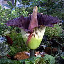

In [30]:
img

In [31]:
type(img)

PIL.Image.Image

In [32]:
X = image.img_to_array(img)

In [33]:
X

array([[[159., 157., 207.],
        [185., 187., 236.],
        [146., 151., 193.],
        ...,
        [ 34.,  44.,  45.],
        [100., 105., 125.],
        [102., 106., 131.]],

       [[185., 174., 216.],
        [170., 163., 204.],
        [113., 109., 146.],
        ...,
        [ 52.,  60.,  71.],
        [ 11.,  26.,  19.],
        [ 39.,  53.,  54.]],

       [[170., 158., 194.],
        [157., 149., 186.],
        [123., 117., 153.],
        ...,
        [ 53.,  65.,  51.],
        [ 86.,  96., 105.],
        [ 79.,  88., 103.]],

       ...,

       [[ 54.,  81.,  66.],
        [ 28.,  54.,  41.],
        [ 63.,  89.,  76.],
        ...,
        [ 11.,  14.,  21.],
        [  2.,   2.,  10.],
        [  5.,   5.,  13.]],

       [[ 50.,  77.,  60.],
        [ 38.,  64.,  51.],
        [ 32.,  58.,  47.],
        ...,
        [  1.,   4.,  11.],
        [  8.,   9.,  11.],
        [  6.,   7.,   9.]],

       [[ 38.,  60.,  47.],
        [  7.,  30.,  14.],
        [  3.,  

In [34]:
X.shape

(64, 64, 3)

In [35]:
import numpy as np

In [37]:
#convolution expects
X = np.expand_dims(X,axis=0)

In [38]:
X.shape

(1, 64, 64, 3)

In [39]:
pred_prob = model.predict(X)

1/1 [==============================] - 0s 118ms/step


In [40]:
pred_prob

array([[0., 1., 0.]], dtype=float32)

In [45]:
class_name=["Bird","Flower","Mammal"]
pred_id = pred_prob.argmax(axis=1)[0]

In [46]:
pred_id

1

In [47]:
print("the predicted dataset is",str(class_name[pred_id]))

the predicted dataset is Flower
